In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import gymnasium as gym

In [2]:
import seaborn as sns
sns.set_style("ticks")
sns.set_context("notebook")

In [3]:
#--BJ class
class BlackJackEnv:
    def __init__(self, episodes, gamma):
        self.EPISODES = episodes # k episodes

        self.rng = np.random.default_rng()
        
        self.env = gym.make('Blackjack-v1', sab=True).env
        
        self.STATES_n0 = self.env.observation_space[0].n #player current sum
        self.STATES_n1 = self.env.observation_space[1].n #dealer's visible card
        self.STATES_n2 = self.env.observation_space[2].n #if player has usable as
        self.ACTIONS_n = self.env.action_space.n #number of actions
    
        self.epsilon = 0.40 # for epsilon greedy search
        self.GAMMA = gamma # discount factor
    
        self.q_func = np.zeros((self.ACTIONS_n, self.STATES_n2, self.STATES_n0, self.STATES_n1)) #start Q-function as zeros

    def _eg_action(self, x, epsilon): #epislon-greedy action
        player_sum, dealer_card, player_as = x
        y = self.rng.random()
        
        if y >= epsilon:
            a = self.env.action_space.sample() # exploration
        else:
            a = self.q_func[:,player_as,player_sum,dealer_card].argmax() # greedy
            
        return a
    
    def _normal_reward(self, system_reward, terminated): #return env reward
        return system_reward

    def _custom_reward(self, system_reward, terminated): #give rewart to hit actions wich dosen't end the game
        if (system_reward == 0.0) and (terminated == False):
            return 0.5
        else:
            return system_reward
        
    #step size functions
    def _lognn(self, n):
        return (np.log(n))/(n)

    def _AB(self, n):
        return 5./(10. + n)
    
    # epsilon functions
    def _cnst_35(self, n):
        return 0.35
    
    def _cnst_50(self, n):
        return 0.50
    
    def _cnst_65(self, n):
        return 0.65
    
    def _epsilon_decay(self, n):
        return 1. - (1./n)
    
    def _epsilon_decay2(self, n):
        return 1./n
    
    def _epsilon_decay3(self, n):
        return 1./(1.+n)


    # Q-learning algorithm
    def q_learn(self, step_func, epsilon_func, reward_func):
        for k in range(self.EPISODES):
            n = 0
            xn, info = self.env.reset() # initial state
            player_sum, dealer_card, player_as = xn
            ep_finished = False
            
            while ep_finished == False:
                n += 1
                step = step_func(n) # alpha_n(xn,an)
                epsilon = epsilon_func(n)
                an = self._eg_action(xn,epsilon)
            
                s, ep_reward, ep_finished, ep_truncation, info = self.env.step(an)
                player_sum_s, dealer_card_s, player_as_s = s
                reward = reward_func(ep_reward,ep_finished)
                    
            
                Qn = self.q_func[an,player_as,player_sum,dealer_card] # Qn(xn,an)
                Wn = self.q_func[:,player_as_s,player_sum_s,dealer_card_s].max() # Wn(s)
                Qit = (1 - step)*Qn + step*(reward + self.GAMMA*Wn) #Q_n+1
            
                self.q_func[an,player_as,player_sum,dealer_card] = Qit
                xn = s
    
    def return_qfunc(self):
        return self.q_func
    
    def return_maxqfunc(self):
        return self.q_func.max(axis = 0)

    def return_drule(self):
        return self.q_func.argmax(axis = 0)
#--end class

In [4]:
def custom_reward(system_reward, terminated): #give rewart to hit actions wich dosen't end the game
    if (system_reward == 0.0) and (terminated == False):
        return 0.5
    else:
        return system_reward

In [5]:
def env_simulation(actions, gamma, reward_func): # simulate enviorenment with given decision rule
    d_rule = actions
    env = gym.make('Blackjack-v1', sab=True).env

    SIMULATIONS = 10000 #number of simulations to perform
    GAMMA = gamma

    rewards = [] # rewards from simulations
    succes_count = 0
    
    for i in range(SIMULATIONS):
        xn, info = env.reset() #x0
        player_sum, dealer_card, player_as = xn
        
        ep_finished = False

        reward_sim = 0. #reawrd from current simulation
        k = 0

        while ep_finished == False:
            k += 1
            an = d_rule[player_as,player_sum,dealer_card]

            s, system_reward, ep_finished, episode_truncation, info = env.step(an)
            reward = reward_func(system_reward, ep_finished)
            reward_sim += (GAMMA**k)*reward #discounted

            xn = s
                
        rewards.append(reward_sim)
        
        if (ep_finished == True) and (system_reward == 1.0):
            succes_count += 1

    sim_rewards_mean = np.array(rewards).mean()
    sim_succes_rate = succes_count/SIMULATIONS

    return sim_rewards_mean, sim_succes_rate

In [6]:
bj_env = BlackJackEnv(500000, 0.95) #enviorement
bj_env.q_learn(bj_env._lognn, bj_env._cnst_50, bj_env._custom_reward) # generate Q-function approximation

maxqfunc = bj_env.return_maxqfunc()
drule = bj_env.return_drule()

In [7]:
mean_rew, succes_rate = env_simulation(drule, 0.95, custom_reward) # simulation of enviorement

print("Media ", mean_rew)
print("Taza ", succes_rate)

Media  -0.15378627823125
Taza  0.3741


Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring unknown font: Computer Modern Serif
Ignoring u

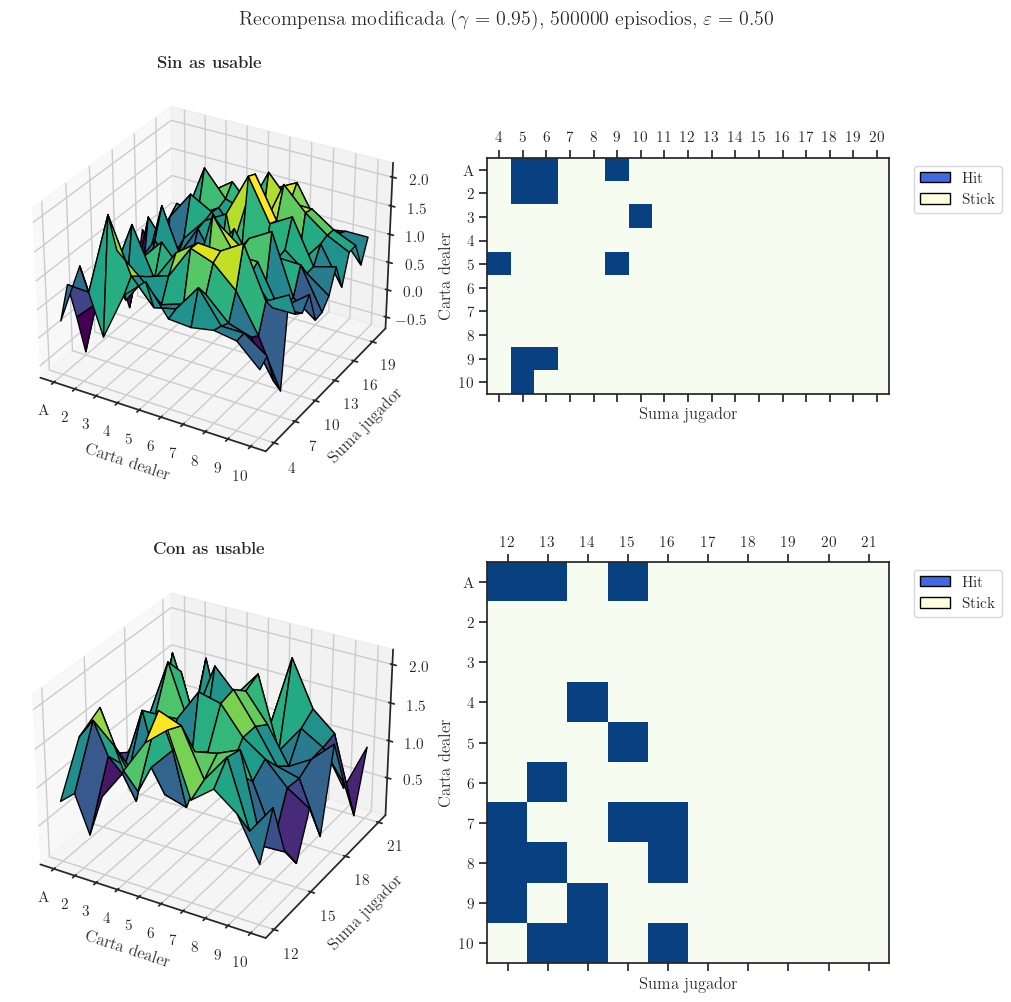

In [9]:
fig = plt.figure(figsize=(10,10), layout='constrained')
plt.rcParams.update({"text.usetex": True,"font.family": "Computer Modern Serif"})

ax1 = fig.add_subplot(2, 2, 1, projection='3d')

y = np.arange(len(maxqfunc[0][4:21,1:]))
x = np.arange(len(maxqfunc[0][0,1:]))

(x,y) = np.meshgrid(x,y)

ax1.plot_surface(x, y, maxqfunc[0][4:21,1:], cmap="viridis", edgecolors='k')
ax1.set_yticks(range(0, 17, 3), labels=range(4, 21, 3))
ax1.set_xticks(range(0, 10, 1), labels=["A"] + list(range(2, 11)))
ax1.set(xlabel="Carta dealer", ylabel="Suma jugador")
ax1.set_title(r"\bf{Sin as usable}", fontsize=12, weight='bold')

ax2 = fig.add_subplot(2, 2, 2)
ax2.matshow(drule[0,4:21,1:].transpose(), cmap='GnBu')
ax2.set_xticks(range(0, 17, 1), labels=range(4, 21, 1))
ax2.set_yticks(range(0, 10, 1), labels=["A"] + list(range(2, 11)))
ax2.set(ylabel="Carta dealer", xlabel="Suma jugador")

legend_elements = [
        Patch(facecolor="royalblue", edgecolor="black", label="Hit"),
        Patch(facecolor="lightyellow", edgecolor="black", label="Stick"),
    ]
ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))

ax3 = fig.add_subplot(2, 2, 3, projection='3d')

y = np.arange(len(maxqfunc[1][12:22,1:]))
x = np.arange(len(maxqfunc[1][0,1:]))

(x,y) = np.meshgrid(x,y)

ax3.plot_surface(x, y, maxqfunc[1][12:22,1:], cmap="viridis", edgecolors='k')
ax3.set_yticks(range(0, 11, 3), labels=range(12, 22, 3))
ax3.set_xticks(range(0, 10, 1), labels=["A"] + list(range(2, 11)))
ax3.set(xlabel="Carta dealer", ylabel="Suma jugador")
ax3.set_title(r"\bf{Con as usable}", fontsize=12)

ax4 = fig.add_subplot(2, 2, 4)
ax4.matshow(drule[1,12:22,1:].transpose(), cmap='GnBu')
ax4.set_xticks(range(0, 10, 1), labels=range(12, 22, 1))
ax4.set_yticks(range(0, 10, 1), labels=["A"] + list(range(2, 11)))
ax4.set(ylabel="Carta dealer", xlabel="Suma jugador")
ax4.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))

fig.suptitle(r"Recompensa modificada ($\gamma=0.95$), 500000 episodios, $\varepsilon = 0.50$")

plt.savefig("blackjack_ejm.pdf", backend='pgf')
plt.show()
plt.close()